In [30]:
import zipfile
import os

def unzip_file(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Example usage:
zip_file_path = "/content/drive/MyDrive/newexample (2).zip"
extracted_folder_path = "/content/"

unzip_file(zip_file_path, extracted_folder_path)

In [31]:
#Required import statements

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, Dense, AveragePooling2D, MaxPool2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import numpy as np
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout
from keras.models import Sequential, Model
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D


In [32]:
# Define the input shape for the model.
# 224 x 224 pixels with 3 color channels (RGB).
input_shape = (224, 224, 3)

In [33]:
# Define the directory paths for training, testing, and validation data
train_directory = '/content/newexample/train'
test_directory = '/content/newexample/test'
val_directory = '/content/newexample/valid'

In [34]:
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Second Convolutional Layer
model.add(Conv2D(filters=192, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Inception Module 1
model.add(Conv2D(filters=64, kernel_size=(1, 1), activation='relu'))
model.add(Conv2D(filters=96, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same'))

# Inception Module 2
model.add(Conv2D(filters=64, kernel_size=(1, 1), activation='relu'))
model.add(Conv2D(filters=96, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same'))

# Flatten the output from the previous layer
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=10, activation='softmax'))


model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_212 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 55, 55, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_213 (Conv2D)         (None, 55, 55, 192)       110784    
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 27, 27, 192)       0         
 ng2D)                                                           
                                                                 
 conv2d_214 (Conv2D)         (None, 27, 27, 64)        12352     
                                                                 
 conv2d_215 (Conv2D)         (None, 27, 27, 96)       

In [35]:
# Get the number of classes in the dataset
folders = glob('/content/newexample/train/*')
num_classes = len(folders)

# Compile the model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [36]:
# Import the ImageDataGenerator class from Keras
from keras.preprocessing.image import ImageDataGenerator

# Define data augmentation and preprocessing for the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Define preprocessing for the testing data (only rescaling is applied)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a data generator for the training set
training_set = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Create a data generator for the test set
test_set = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Print the number of batches in the training and test sets
print("Number of batches in the training set:", len(training_set))
print("Number of batches in the test set:", len(test_set))



Found 1601 images belonging to 10 classes.
Found 403 images belonging to 10 classes.
Number of batches in the training set: 51
Number of batches in the test set: 13


In [37]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load the pre-trained GoogLeNet (InceptionV3) model without the top (classification) layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the weights of the GoogLeNet layers
for layer in base_model.layers:
    layer.trainable = False

# Add your custom fully connected layers after the GoogLeNet layers
x = base_model.output
x = Flatten()(x)
x = Dense(units=1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(units=1024, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(units=10, activation='softmax')(x)

# Create your custom model by combining the GoogLeNet base with the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data and validate on the test data
r = model.fit(
    training_set,
    validation_data=test_set,
    # Number of training epochs
    epochs=20,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)


Epoch 1/20
51/51 [==============================] - 30s 491ms/step - loss: 9.3110 - accuracy: 0.6621 - val_loss: 1.8978 - val_accuracy: 0.8734
Epoch 2/20
51/51 [==============================] - 24s 470ms/step - loss: 2.2968 - accuracy: 0.8282 - val_loss: 0.8387 - val_accuracy: 0.9132
Epoch 3/20
51/51 [==============================] - 24s 465ms/step - loss: 1.1856 - accuracy: 0.8613 - val_loss: 0.2345 - val_accuracy: 0.9553
Epoch 4/20
51/51 [==============================] - 22s 426ms/step - loss: 0.5069 - accuracy: 0.9007 - val_loss: 0.2811 - val_accuracy: 0.9529
Epoch 5/20
51/51 [==============================] - 23s 451ms/step - loss: 0.5076 - accuracy: 0.8882 - val_loss: 0.0956 - val_accuracy: 0.9677
Epoch 6/20
51/51 [==============================] - 23s 450ms/step - loss: 0.4322 - accuracy: 0.9119 - val_loss: 0.1051 - val_accuracy: 0.9752
Epoch 7/20
51/51 [==============================] - 23s 456ms/step - loss: 0.4369 - accuracy: 0.9051 - val_loss: 0.1439 - val_accuracy: 0.9578

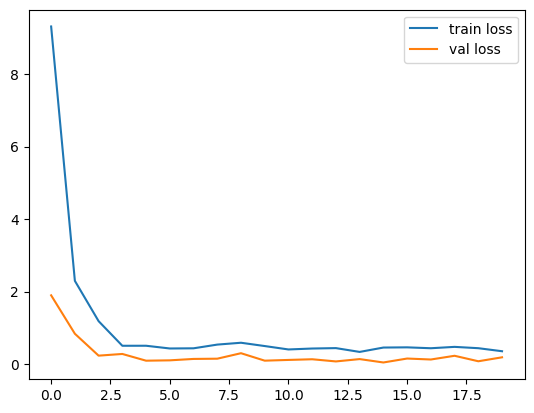

In [38]:
    # Loss
# Plot the training loss for each epoch
plt.plot(r.history['loss'], label='train loss')

if 'val_loss' in r.history:
# Plot the validation loss for each epoch, if available
 plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

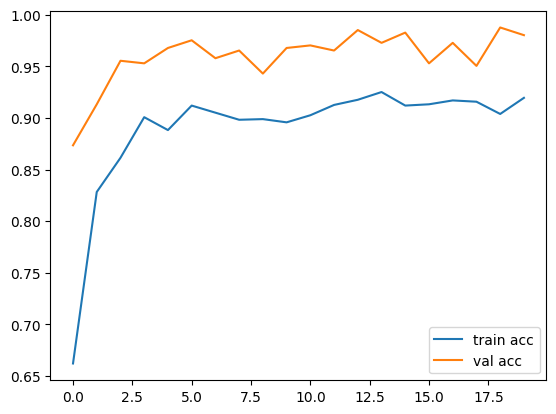

In [39]:
# Accuracies
plt.plot(r.history['accuracy'], label='train acc')
if 'val_accuracy' in r.history:
    plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
model.save('Googlenet.h5')

In [40]:

from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array

model1 = load_model('./Googlenet.h5',compile=False)

lab = training_set.class_indices
lab={k:v for v,k in lab.items()}

In [41]:
def output(location):
    # Load the image from the given location and resize it to the input size (224x224x3)
    img = load_img(location, target_size=(224, 224, 3))

    # Convert the image to a NumPy array
    img = img_to_array(img)
    img = img / 255
    img = np.expand_dims(img, [0])

    # Use the pre-trained model (model1) to predict the class of the image
    answer = model1.predict(img)
    y_class = answer.argmax(axis=-1)
    y = int(y_class)
    res = lab[y]
    # Return the predicted class label for the given image location
    return res


1/1 [==============================] - 2s 2s/step


<ipython-input-41-6e7f41a311f7>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(y_class)


'ABBOTTS BOOBY'

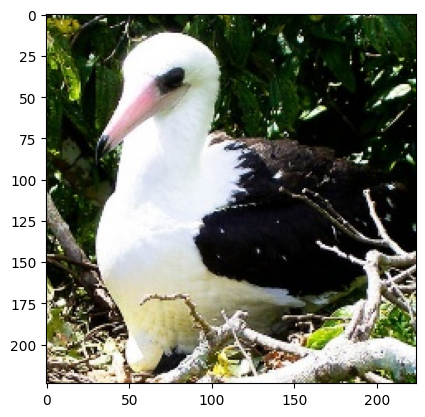

In [43]:
# Image File Path
img='/content/newexample/valid/ABBOTTS BOOBY/2.jpg'
# Load and Display the Image
pic=load_img(img,target_size=(224,224,3))
plt.imshow(pic)
output(img)

13/13 [==============================] - 3s 91ms/step


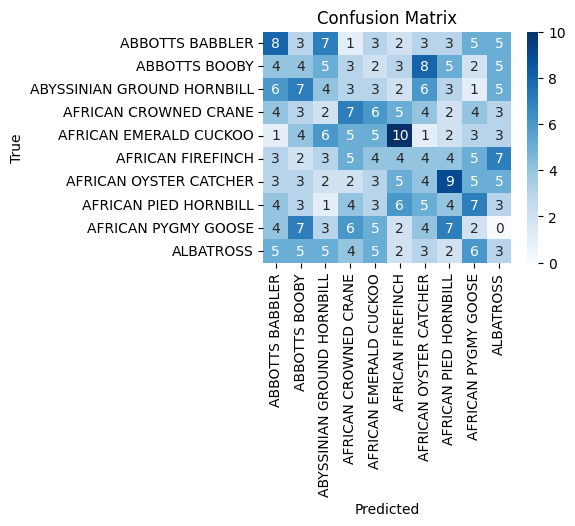

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predicted labels for the test set
Y_true = test_set.classes
Y_pred = model.predict(test_set).argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Get class names
class_names = list(test_set.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()